In [1]:
import os
import sys
import glob2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchaudio

In [4]:
device = 'cuda:0'

In [5]:
data_root_vox1_dev = "/home/alexey/Documents/data/vox1_dev/wav"

In [1]:
!git clone https://github.com/clovaai/voxceleb_trainer.git

Cloning into 'voxceleb_trainer'...
remote: Enumerating objects: 204, done.
remote: Total 204 (delta 0), reused 0 (delta 0), pack-reused 204
Receiving objects: 100% (204/204), 86.55 KiB | 895.00 KiB/s, done.
Resolving deltas: 100% (114/114), done.


In [2]:
!mkdir -p pretrained/clova

In [3]:
!wget http://www.robots.ox.ac.uk/~joon/data/baseline_v2_ap.model -P pretrained/clova

--2021-11-16 21:10:54--  http://www.robots.ox.ac.uk/~joon/data/baseline_v2_ap.model
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.robots.ox.ac.uk/~joon/data/baseline_v2_ap.model [following]
--2021-11-16 21:10:59--  https://www.robots.ox.ac.uk/~joon/data/baseline_v2_ap.model
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 44573290 (43M)
Saving to: ‘pretrained/clova/baseline_v2_ap.model’

baseline_v2_ap.mode 100%[===================>]  42,51M   912KB/s    in 46s     

2021-11-16 21:11:45 (943 KB/s) - ‘pretrained/clova/baseline_v2_ap.model’ saved [44573290/44573290]



In [6]:
sys.path.append("voxceleb_trainer")

In [7]:
def prepare_model_clova(model_path, n_mels=64):

    from voxceleb_trainer.models.ResNetSE34V2 import MainModel

    clova_state = torch.load(model_path)
    model = MainModel(nOut=512, encoder_type='ASP', n_mels=n_mels)
    default_state = model.state_dict()

    for name, param in clova_state.items():
        if '__S__' in name:
            valid_name = name[6:]
            if valid_name not in default_state:
                continue

            if default_state[valid_name].size() != param.size():
                print(f'mismatched size: model: {default_state[valid_name].size()}; state: {param.size()}')
                continue

            default_state[valid_name].copy_(param);

    model.requires_grad_(False)
    model.eval()
    return model

In [8]:
model_path = 'pretrained/clova/baseline_v2_ap.model'

In [9]:
emb_model = prepare_model_clova(model_path)
emb_model = emb_model.to(device)

Embedding size is 512, encoder ASP.


In [22]:
def extract_embeddings(embedder, data_root, path2utt_fn=lambda p:p, batch_size=1, crop_size=None, crop_center=True, file_ext='wav', subset=None):
    
    embedder = embedder.eval()
    
    wav_files = glob2.glob(f'{data_root}/**/*.{file_ext}')
    
    if subset is not None:
        wav_files = [wav for wav in wav_files if path2utt_fn(wav) in subset]
        print('Subset:', len(subset))
        print('Found:', len(wav_files))
    
    if crop_size is None:
        assert batch_size == 1
    crop_size_half = int(0.5 * crop_size)

    embeddings = []
    utt_ids = []

    signals_batch = []
    counter = 0
    for i, wav_path in enumerate(tqdm(wav_files)):

        utt_id = path2utt_fn(wav_path)
        utt_ids += [utt_id]

        signal, _ = torchaudio.load(wav_path)
        length = signal.shape[-1]
        length_half = int(0.5*length) 
        
        if crop_size is not None:
            if crop_center:
                start = max(0, length_half - crop_size_half)
                signal_crop = signal[..., start:start + crop_size] 
            else:
                signal_crop = signal[..., :crop_size] 
                
            # pad if signal is too short
            if crop_size > length:
                pad_size = (0, crop_size - length)
                signal_crop = F.pad(signal_crop, pad_size)

        signals_batch += [signal_crop]
        counter += 1

        if counter % batch_size == 0 or (i+1) == len(wav_files):
            with torch.no_grad():
                emb_batch = embedder(torch.cat(signals_batch).to(device)).cpu()

            embeddings += [emb_batch]
            signals_batch = []
            counter = 0
            
    return embeddings, utt_ids

In [11]:
batch_size = 512

crop_size = 16000
crop_center = True

path2utt_fn_vox = lambda wav_path: wav_path.split('/wav/')[-1]
utt2spk_fn_vox = lambda utt: utt.split('/')[0]

In [12]:
embeddings, utt_ids = extract_embeddings(emb_model, 
                                         data_root_vox1_dev, 
                                         path2utt_fn_vox, 
                                         batch_size=batch_size, 
                                         crop_size=crop_size, 
                                         crop_center=crop_center)


100%|██████████| 148642/148642 [14:58<00:00, 165.49it/s]


In [13]:
embeddings = torch.cat(embeddings).cpu().numpy()

In [14]:
labels = [utt2spk_fn_vox(utt) for utt in utt_ids]

In [15]:
len(embeddings), len(utt_ids), len(labels)

(148642, 148642, 148642)

In [16]:
np.savez('./emb_vox1dev_clova_1sec', X=embeddings, ids=utt_ids, y=np.unique(labels, return_inverse=True)[1])

In [11]:
data_root_asvspoof2019_train = "/home/alexey/Documents/datasets/ASVspoof2019/PA/ASVspoof2019_PA_train"

In [32]:
batch_size = 128

crop_size = 16000
crop_center = True
file_ext = 'flac'

path2utt_fn_asvspoof = lambda wav_path: wav_path.split('/')[-1].split('.')[0]
utt2spk_fn_asvspoof = lambda utt: utt.split('/')[0]

In [33]:
with open('../household/ASVspoof2019_train.txt', 'r') as f:
    utt_ids = set([line.strip() for line in f.readlines()])

In [34]:
len(utt_ids)

5400

In [35]:
embeddings, utt_ids = extract_embeddings(emb_model, 
                                         data_root_asvspoof2019_train, 
                                         path2utt_fn_asvspoof, 
                                         batch_size=batch_size, 
                                         crop_size=crop_size, 
                                         crop_center=crop_center,
                                         file_ext=file_ext, 
                                         subset=utt_ids)


  2%|▏         | 100/5400 [00:00<00:05, 995.39it/s]

Subset: 5400
Found: 5400


100%|██████████| 5400/5400 [00:08<00:00, 623.80it/s]


In [36]:
embeddings = torch.cat(embeddings).cpu().numpy()

In [37]:
embeddings.shape

(5400, 512)

In [38]:
#labels = [utt2spk_fn_asvspoof(utt) for utt in utt_ids]

In [39]:
len(embeddings), len(utt_ids)#, len(labels)

(5400, 5400)

In [40]:
np.savez('./emb_asvspoof2019_train_clova_1sec', X=embeddings, ids=utt_ids)

In [64]:
data_root_asvspoof2019_train = "/home/alexey/Documents/datasets/ASVspoof2019/PA/ASVspoof2019_PA_eval"

In [65]:
batch_size = 256

crop_size = 32000
crop_center = True
file_ext = 'flac'

path2utt_fn_asvspoof = lambda wav_path: wav_path.split('/')[-1].split('.')[0]
utt2spk_fn_asvspoof = lambda utt: utt.split('/')[0]

In [66]:
with open('../household/ASVspoof2019_eval_test.txt', 'r') as f:
    utt_ids = set([line.strip() for line in f.readlines()])

In [67]:
len(utt_ids)

129600

In [68]:
embeddings, utt_ids = extract_embeddings(emb_model, 
                                         data_root_asvspoof2019_train, 
                                         path2utt_fn_asvspoof, 
                                         batch_size=batch_size, 
                                         crop_size=crop_size, 
                                         crop_center=crop_center,
                                         file_ext=file_ext, 
                                         subset=utt_ids)


  0%|          | 94/129600 [00:00<02:18, 937.18it/s]

Subset: 129600
Found: 129600


100%|██████████| 129600/129600 [28:15<00:00, 76.45it/s] 


In [69]:
embeddings = torch.cat(embeddings).cpu().numpy()

In [70]:
embeddings.shape

(129600, 512)

In [71]:
len(embeddings), len(utt_ids)#, len(labels)

(129600, 129600)

In [72]:
np.savez('./emb_asvspoof2019_eval_test_clova_2sec', X=embeddings, ids=utt_ids)

In [73]:
batch_size = 512

crop_size = 16000
crop_center = True
file_ext = 'flac'

path2utt_fn_asvspoof = lambda wav_path: wav_path.split('/')[-1].split('.')[0]
utt2spk_fn_asvspoof = lambda utt: utt.split('/')[0]

In [74]:
with open('../household/ASVspoof2019_eval_test.txt', 'r') as f:
    utt_ids = set([line.strip() for line in f.readlines()])

In [75]:
len(utt_ids)

129600

In [76]:
embeddings, utt_ids = extract_embeddings(emb_model, 
                                         data_root_asvspoof2019_train, 
                                         path2utt_fn_asvspoof, 
                                         batch_size=batch_size, 
                                         crop_size=crop_size, 
                                         crop_center=crop_center,
                                         file_ext=file_ext, 
                                         subset=utt_ids)


  0%|          | 87/129600 [00:00<02:29, 868.51it/s]

Subset: 129600
Found: 129600


100%|██████████| 129600/129600 [27:21<00:00, 78.97it/s] 


In [77]:
embeddings = torch.cat(embeddings).cpu().numpy()

In [78]:
embeddings.shape

(129600, 512)

In [79]:
len(embeddings), len(utt_ids)#, len(labels)

(129600, 129600)

In [80]:
np.savez('./emb_asvspoof2019_eval_test_clova_1sec', X=embeddings, ids=utt_ids)

In [22]:
len(np.unique(labels))

1211

In [23]:
# sanity check

def cosine(a, b):
    a, b = torch.tensor(a), torch.tensor(b)
    a_ln, b_ln = a / torch.norm(a, dim=1, keepdim=True), b / torch.norm(b, dim=1, keepdim=True)
    return torch.mm(a_ln, b_ln.t()).numpy()

similarity_score = cosine



y = np.unique(labels, return_inverse=True)[1]

sc_tar = []
sc_imp = []

for i in range(5):
    for j in range(i, 5):
        mask1 = y == i
        x1 = embeddings[mask1]
        mask2 = y == j
        x2 = embeddings[mask2]
        
        if i == j:
            #print(x1.shape, x2.shape)
            sc_tar += [similarity_score(x1, x2).ravel()]
        else:
            #print(x1.shape, x2.shape)
            sc_imp += [similarity_score(x1, x2).ravel()]
            
sc_tar = np.concatenate(sc_tar)
sc_imp = np.concatenate(sc_imp)

print(len(sc_imp), len(sc_tar))
print(np.mean(sc_imp), np.mean(sc_tar))

115320 67476
0.12526798 0.501915


In [24]:
len(sc_tar)/len(sc_imp)

0.5851196670135276

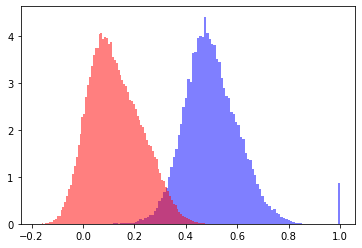

In [25]:
plt.hist(sc_tar, bins=100, density=True, alpha=0.5, color='b');
plt.hist(sc_imp, bins=100, density=True, alpha=0.5, color='r');

In [1]:
weights_path = 'pretrained/VBx/ResNet101_16kHz/nnet/final.onnx'
backend = 'onnx'

import onnxruntime

def get_embedding(fea, model, label_name=None, input_name=None, backend='pytorch'):
    if backend == 'pytorch':
        data = torch.from_numpy(fea).to(device)
        data = data[None, :, :]
        data = torch.transpose(data, 1, 2)
        spk_embeds = model(data)
        return spk_embeds.data.cpu().numpy()[0]
    elif backend == 'onnx':
        return model.run([label_name],
                  {input_name: fea.astype(np.float32).transpose()
                  [np.newaxis, :, :]})[0].squeeze()

if backend == 'pytorch':
    raise NotImplementedError
#     if args.model_file is not None:
#         model = torch.load(args.model_file)
#         model = model.to(device)
#     elif args.model is not None and weights_path is not None:
#         model = eval(args.model)(feat_dim=args.ndim, embed_dim=args.embed_dim)
#         model = model.to(device)
#         checkpoint = torch.load(weights_path, map_location=device)
#         model.load_state_dict(checkpoint['state_dict'], strict=False)
#         model.eval()
elif backend == 'onnx':
    model = onnxruntime.InferenceSession(weights_path)
    input_name = model.get_inputs()[0].name
    label_name = model.get_outputs()[0].name

else:
    raise ValueError('Wrong combination of --model/--weights/--model_file '
                     'parameters provided (or not provided at all)')

In [13]:
import features

samplerate = 16000
noverlap = 240
winlen = 400
window = features.povey_window(winlen)
fbank_mx = features.mel_fbank_mx(winlen, samplerate, NUMCHANS=64, LOFREQ=20.0, HIFREQ=7600, htk_bug=False)

fea = features.fbank_htk(signal.view(-1).numpy(), window, noverlap, fbank_mx, USEPOWER=True, ZMEANSOURCE=True)
LC = 150
RC = 149
fea = features.cmvn_floating_kaldi(fea, LC, RC, norm_vars=False).astype(np.float32)

xvector = get_embedding(fea, model, label_name=label_name, input_name=input_name, backend=backend)

xvector.shape

(256,)

In [81]:
signal = torch.randn(1, 32000)

In [82]:
import torchaudio
from speechbrain.pretrained import EncoderClassifier
classifier = EncoderClassifier.from_hparams(source="speechbrain/spkrec-ecapa-voxceleb")

In [89]:
embeddings = classifier.encode_batch(signal.to(device))

In [90]:
embeddings.shape

torch.Size([1, 1, 192])

In [91]:
embeddings.device

device(type='cpu')

In [92]:
EncoderClassifier

speechbrain.pretrained.interfaces.EncoderClassifier

In [97]:
torch.norm(embeddings)

tensor(378.5052)